# Building Credit Risk Models


**What is Credit Risk?**

Credit risk is the risk that a customer will not pay back(also known as **default**) the lender as per the expected schedule. This risk is central to how lending fintech organizations run. 

In cobnventional lending organizations, and in fact all lending organization a 100 years back, there are employees who are in charge odf assessing the credit risk of each borrower. They look at parameters such as your previous credit history(which they get from a credit bereau), income, marital status, coccupation and educational/professional qualifications.

Different financial organizatins are at different levels of automating the credit risk process because of technology, talent and different regulations. however, most all organizations involved in the lending business hire data scientists who specialize in building credit risk model in house.

### Why use models?

- they are cheaper
- they are faster
- dont exhibit human bias and variance
- depending on the quality and quantity of the data that was used to train it, might make decisions with equal accuracy to a traine credit professional.


For a while now, developing and maintaining scoe cards has **a very positive ROI for financial institutions**. You will see every lender implement and maintain their own scorecard. As such, the credit risk industry is one of the oldest employers of data scientists, even before the current data science boom.

This has been possible because of :

- Availability of highly structured information digitally (from credit bureaus)
- Scale 
- Storage and compute becoming cheaper

### Defining the objective?

- **Improve Productivity** or partial automation iin the risk assessment workflow. You want to take similar quality decisions but faster, with less resources. benchmark is the time and resources being used currently.

- **Control Credit Risk**. You want to make beter decisions than the current setup. Benchmark current portfolio quality and default rates.

- Access the quality of the current portfolio and estimate the **Portfolio Risk**. Benchmark is the current model

We can build a credit risk model which can **approve/reject** loan applications based on all the data points we capture in the application. eradicating manual judgements as the model will make the final decisions.


building the loan application scoring model. We also have to figure out probability decsion boundary for approval/rejection.

- What are the features we can use? We can only use features which were available at the application stage.

- What should be the output of the model? the model hqs to output a decision rather than a probability score.


We can frame this as a **supervised binary classification problem**. the model will be trained on past loans where target is already known. Each of these loans would either have defaulted or not.

# Creating the Dataset

### The Target

Till now we have only alluded to "default" in an abstract sense. However, to create the target variable from historical data, we will need an exact definition. From the regulatory business definitions default usually refers to the same thing across organizations. 

For term loans with EMIs, it is usually the event of a borrower missing 3 consecutive monthly payments (90 days past due)

### The Features

- Calculate the features in a way that is replicable when the model will be deployed.
- Create as many features as possible.
- Feature engineering is very important.



dataset - https://www.kaggle.com/c/home-credit-default-risk

## Building the model

### Feature exploration and selection

We try to understand the feature distributions and thier relationships with the target variable. in binary classification problems, the metrics generally used to measure bivariate relationship strength is the **Infromation value**.

https://multithreaded.stitchfix.com/blog/2015/08/13/weight-of-evidence/

The metric is rooted in information theory, specifically the jensen shanon divergence. Think of this like the equivalent of Persason correlation, which is used when the target variable is continous. We will rely on the optbinning package to calculate this.

In [1]:
import pandas as pd
import numpy as np
import utils
import py_mob
from tqdm import tqdm

In [2]:
data_in = pd.read_csv("application_train.csv").drop(columns="SK_ID_CURR")

In [3]:
data_in

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,0,Cash loans,M,N,N,0,157500.0,254700.0,27558.0,225000.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
307507,0,Cash loans,F,N,Y,0,72000.0,269550.0,12001.5,225000.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
307508,0,Cash loans,F,N,Y,0,153000.0,677664.0,29979.0,585000.0,...,0,0,0,0,1.0,0.0,0.0,1.0,0.0,1.0
307509,1,Cash loans,F,N,Y,0,171000.0,370107.0,20205.0,319500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
data_in["TARGET"].value_counts(normalize=True)

TARGET
0    0.919271
1    0.080729
Name: proportion, dtype: float64

We can see that around 8% of our dataset are defaulters

In [5]:
from optbinning import OptimalBinning
from pandas.api.types import is_numeric_dtype

In [6]:
target = "TARGET"
features = [x for x in data_in.columns if x!= target]

binned_features = {}

In [7]:
def get_binning(x, y, params={}):
    '''
    Function o get binning result for independent variable with the target variable y
    '''
    
    if is_numeric_dtype(x):
        optb = OptimalBinning(name=feat, dtype="numerical", solver="cp", **params)
    else:
        optb = OptimalBinning(name=feat, dtype="categorical", solver="mip", **params)
    optb.fit(x, y)
    
    binning_table = optb.binning_table
    binning_table.build()
    return binning_table, optb


for feat in features:
    x = data_in[feat].values
    y = data_in[target]
    
    binning_result = get_binning(x, y)
    binned_features.update({feat: binning_result})
    

In [8]:
feature_strength = pd.DataFrame([ (x, y[0].iv) for x, y in binned_features.items() ]).rename(columns = {0:"feature", 1:"iv"}).sort_values("iv", ascending=False)
feature_strength.head(10)

,feature,iv
41,EXT_SOURCE_3,0.335262
40,EXT_SOURCE_2,0.321683
39,EXT_SOURCE_1,0.146393
16,DAYS_EMPLOYED,0.114354
8,AMT_GOODS_PRICE,0.092037
15,DAYS_BIRTH,0.087245
26,OCCUPATION_TYPE,0.079610
38,ORGANIZATION_TYPE,0.071642
6,AMT_CREDIT,0.059368
10,NAME_INCOME_TYPE,0.057869


Now we look at each feature to find out what the **information value**, a higher number is a stronger association. from 0.05 sighnifies a good relationship. "EXT_SOURCE_3" has the highest

In [9]:
feature_strength.tail(10)

,feature,iv
105,FLAG_DOCUMENT_13,0.0
104,FLAG_DOCUMENT_12,0.0
103,FLAG_DOCUMENT_11,0.0
20,FLAG_MOBIL,0.0
101,FLAG_DOCUMENT_9,0.0
99,FLAG_DOCUMENT_7,0.0
97,FLAG_DOCUMENT_5,0.0
96,FLAG_DOCUMENT_4,0.0
23,FLAG_CONT_MOBILE,0.0
94,FLAG_DOCUMENT_2,0.0


In [10]:
# Percentile distribution of IVs
feature_strength.iv.describe(np.linspace(0,1,11))

count    120.000000
mean       0.027153
std        0.045787
min        0.000000
0%         0.000000
10%        0.000000
20%        0.000666
30%        0.011504
40%        0.013225
50%        0.017755
60%        0.022416
70%        0.028736
80%        0.033208
90%        0.048451
100%       0.335262
max        0.335262
Name: iv, dtype: float64

We can see that about 10% are greater than 0.05 compared to the 90% that are from 0.04.

**Conclusion:**  
    
A lot of features have very low IV(<0.05). Generally we have compute constraints and thus want to remove features which will not add to our model. nevertheless, any feature that has even a sight predictive ability should be included in the training process and the model should itself learn how important it is.
    
    
Since we are not training a linear regression model we are not overly concerned its collinearity.

## Exploring individual features

So far we have looked at one number/value that measures the strength and we have seen which varibles are stronger. Now we will be looking at one of the variables and see (because we have alredy figured out that 10 or 12 variables are important), then we look at their actual relationship with the target variable. 

The IV is only a number which gives the strength of the relationship but you are not really sure what is the nature of the relationship which is also very important. 

If we dont understand the nature of the relationship we will not use a variable in the lmodel even if we feel that it is very strong. 

In [11]:
binned_features['DAYS_BIRTH'][0].build()

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, -23196.50)",15500,0.050405,14823,677,0.043677,0.653779,1.645258e-02,2.020712e-03
1,"[-23196.50, -20726.50)",41254,0.134155,39035,2219,0.053789,0.434917,2.118060e-02,2.626903e-03
2,"[-20726.50, -19865.50)",16383,0.053276,15440,943,0.057560,0.363165,6.040525e-03,7.509435e-04
3,"[-19865.50, -18796.50)",20818,0.067698,19425,1393,0.066913,0.202616,2.553571e-03,3.186515e-04
4,"[-18796.50, -17367.50)",26196,0.085187,24325,1871,0.071423,0.132546,1.415852e-03,1.768521e-04
5,"[-17367.50, -15327.50)",43050,0.139995,39754,3296,0.076562,0.057515,4.520789e-04,5.650207e-05
6,"[-15327.50, -14654.50)",15754,0.051231,14485,1269,0.080551,0.002399,2.945248e-07,3.681559e-08
7,"[-14654.50, -14017.50)",15395,0.050063,14109,1286,0.083534,-0.037209,7.040428e-05,8.800027e-06
8,"[-14017.50, -13366.50)",15639,0.050857,14241,1398,0.089392,-0.111403,6.613719e-04,8.262876e-05
9,"[-13366.50, -12630.50)",16097,0.052346,14547,1550,0.096291,-0.193356,2.122491e-03,2.648989e-04


The "DAYS_BIRTH"column is the age of the applicant. A negative number signifies a higher age and as you go towards a positive number it signifies a lower age.

Reading this table can be overwhelming but generally just focus on the Bin and the Event rate. 

The Bin is a float that has broken down the DAYS_BIRTH into 20 bins, in an increasing order. Increasing order in this number means decreasing order in age. So as you move down the age actually decreases

The Event rate is actually the default rate and within this age bracket, out of the total people that are ther("Count") which is like 15,500. What are the events? So "Events" is actually the defaulters and the event rate is actually 4.3% which is quite low because overall we saw its 8.7%. But within that age bracket this is actually 4%

Notice that as you increase the age of an applicant as you go don the bins, the event rate keeps going up. 

So this is a relationship that is very intuitive to people, who have done any credit risk modelling is that age is a very strong predictor of credit risk. The general trend is that as your age increases your earning capacity increases and the more your earning capacity the better borrower you are and the less likely you are to default.

So in an ideal scenario it is advisable to go over every variable that i want to feed into my model and see if that relationship makes sense given your intuition as a credit risk person, if it makes sense or not to either use it or not regardless of it having a strong association or not.

In [12]:
selected_features = [ feat_name for feat_name, iv in zip(feature_strength["feature"], feature_strength["iv"]) if iv>0.05]

In [13]:
len(selected_features)

11

In [14]:
data_in[selected_features].dtypes

EXT_SOURCE_3                   float64
EXT_SOURCE_2                   float64
EXT_SOURCE_1                   float64
DAYS_EMPLOYED                    int64
AMT_GOODS_PRICE                float64
DAYS_BIRTH                       int64
OCCUPATION_TYPE                 object
ORGANIZATION_TYPE               object
AMT_CREDIT                     float64
NAME_INCOME_TYPE                object
REGION_RATING_CLIENT_W_CITY      int64
dtype: object

## Model Training

### Why choose tree models

- Scale invariant
- Robust to multicolinearity.
- Robust to outliers.
- Proven to be SOTA for tabular data modelling.
- LightGBM additionally handles categotical variables as well.

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')

In [16]:
# paramter grid for XGBoost
params = {
    'min_child_weight': [1, 5, 10],
    'max_depth': [3, 4],
    'learning_rate': [0.001, 0.01, 0.1],
    'colsample_bytree': [0.1, 0.2]
}



clf = lgb.LGBMClassifier(
    verbose_eval = False,
    objective = 'binary',
    boosting_type = 'gbdt',
    seed = 0,
    verbose = -1,
    metric = 'auc',
    nthread = 16
)

folds = 3

In [17]:
# Always use stratified sampling
skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=1002)

data_features = data_in[selected_features]
data_target = data_in[target]

In [18]:
for c in data_features.columns:
    if data_features[c].dtype.name == 'object':
        data_features[c] = data_features[c].astype('category')

In [19]:
X_train, X_test, y_train, y_test = train_test_split(data_features, data_target, test_size=0.33, random_state=42)

In [20]:
grid_search = GridSearchCV(clf, param_grid=params, scoring='roc_auc', n_jobs=4, cv=skf.split(X_train, y_train), verbose=3)

In [21]:
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=16 will be ignored. Current value: num_threads=-1


GridSearchCV(cv=<generator object _BaseKFold.split at 0x0000019A54E51120>,
             estimator=LGBMClassifier(metric='auc', nthread=16,
                                      objective='binary', seed=0, verbose=-1,
                                      verbose_eval=False),
             n_jobs=4,
             param_grid={'colsample_bytree': [0.1, 0.2],
                         'learning_rate': [0.001, 0.01, 0.1],
                         'max_depth': [3, 4], 'min_child_weight': [1, 5, 10]},
             scoring='roc_auc', verbose=3)

In [22]:
print(grid_search.best_params_, grid_search.best_score_)

{'colsample_bytree': 0.2, 'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 10} 0.7422060319438013


In [23]:
feature_importance_df = pd.DataFrame()
feature_importance_df["feature"] = selected_features
feature_importance_df["importance"] = grid_search.best_estimator_.feature_importances_

In [24]:
feature_importance_df.sort_values("importance", ascending=False)

,feature,importance
4,AMT_GOODS_PRICE,291
8,AMT_CREDIT,202
0,EXT_SOURCE_3,199
6,OCCUPATION_TYPE,183
2,EXT_SOURCE_1,165
1,EXT_SOURCE_2,83
10,REGION_RATING_CLIENT_W_CITY,83
3,DAYS_EMPLOYED,79
7,ORGANIZATION_TYPE,62
5,DAYS_BIRTH,57


In [25]:
classifier = grid_search.best_estimator_
classifier.fit(X_train, y_train)

y_train_probs = classifier.predict_proba(X_train)[:, 1]
y_test_probs = classifier.predict_proba(X_test)[:, 1]

train_auc = roc_auc_score(y_train, y_train_probs)
test_auc = roc_auc_score(y_test, y_test_probs)

print(f"Model results. Train AUC : {train_auc}, Test AUC : {test_auc}")

Model results. Train AUC : 0.7527438849352787, Test AUC : 0.7432056466058533


In [26]:
from utils import ks
test_result_df = pd.DataFrame({"target": y_test, "proba": y_test_probs})
summary_table = ks(test_result_df, "target", "proba")
summary_table

,min_prob,max_prob,events,nonevents,total,bucket_event_rate,event_rate,nonevent_rate,cum_eventrate,cum_noneventrate,KS
Decile,,,,,,,,,,,
1,0.165369,0.740046,2568,7580,10148,0.253055,31.64%,8.12%,31.64%,8.12%,23.5
2,0.116524,0.165356,1455,8693,10148,0.143378,17.93%,9.31%,49.56%,17.43%,32.1
3,0.090638,0.116522,1112,9036,10148,0.109578,13.70%,9.68%,63.26%,27.11%,36.2
4,0.073162,0.090638,753,9395,10148,0.074202,9.28%,10.06%,72.54%,37.17%,35.4
5,0.059845,0.073162,655,9492,10147,0.064551,8.07%,10.17%,80.61%,47.34%,33.3
6,0.049325,0.059844,490,9658,10148,0.048285,6.04%,10.34%,86.65%,57.68%,29.0
7,0.040503,0.049323,399,9749,10148,0.039318,4.92%,10.44%,91.56%,68.13%,23.4
8,0.032363,0.040503,311,9837,10148,0.030646,3.83%,10.54%,95.39%,78.66%,16.7
9,0.024156,0.032361,231,9917,10148,0.022763,2.85%,10.62%,98.24%,89.28%,9.0


As the AUC tells us how well our model is performing in terms of distinguishing between defaulters adthe non defaulters. 

But it doesnt tell you if it can use it to approve or reject applications. So for that, we create a table to breakdown the whole population that i have already created and done my scoring, andd model on with the target as well.

looking at the 1st decile which represents 10% of the population, which has the highest probability of default - worst people according to our model and they have a default rate of 31.64%

the second bucket is also worse than everybody else but better than the first bucket. they have a default rate of 17.93%. 

By using this table we can easily decide on where we want to put our decision threshhold. because we have trained the model but the model itself is not what the ask is. The ask is to have a system that can either approve or reject. So we have to figure out in addition to the model probabilities that we predicted what is the threshhold that we are going to apply and say that if the risk of default is higher than that then we will reject it.


For example lets say we chose a threshhold - people who have a probability greater than 0.11 probability of default according to my model. it means we will have to reject both the 1st and 2nd decile. it means that 80% will be approved while 20% will not. But we should also note that these 20% have really high default rates so we avoid them but we are okay with taking the risk with the other 80%. and this is the decision that you cant take a a data scientist, you have to discuss with the 'head of risk', 'business head' etc but this is the sort of metric you will have to show them as the decision choices because you cant just tell them that the AUC is high.


This is how we create a system out of our model as the model alone is just outputing probabilities, our job is to create a system ontop the model which has to have a decision boundary. 


## Explainability in credit risk models

### Shapley Values

Shapley values breaks down every prediction as a sum of contribution of each individual feature. So if you have 3 features, lets say Age, income and number of children, if we se a tree based model maybe the model output is or probability is 0.5 for default but how do we attribute that to what came out of age, income etc.  

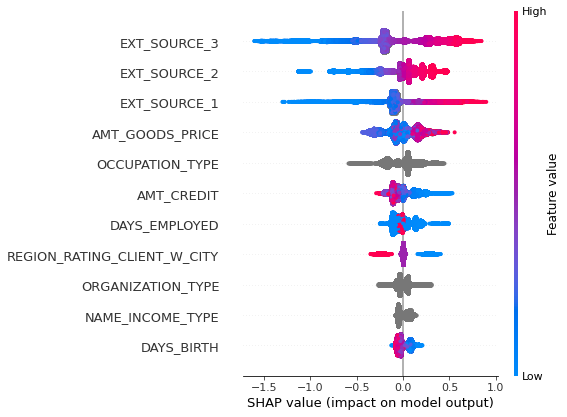

In [29]:
import shap
explainer = shap.TreeExplainer(classifier.booster_)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values[0], X_train)

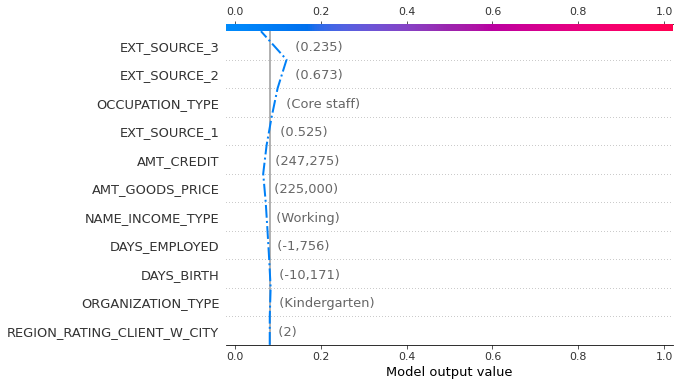

In [31]:
obs_idx = 780  # relating to a specific observation

shap.decision_plot(np.log(y_train_probs.mean()/(1-y_train_probs.mean())), shap_values[0][obs_idx], X_train.iloc[obs_idx], link='logit', highlight=0)

In [32]:
y_train_probs[780]

0.08398241343508302

the grayline represents the average prediction - the average default rate. the dash lines show easch feature contribution towards changing what the average prediction would have been.

For example EXT_SOURCE_2 actually causes the prediction to become positive so whatever the value of EXT_SOURCE_2 which is 0.673 for this specific person, that actually makes him slightly higher risk than average. but the EXT_SOURCE_3 which is 0.235 for this person compensates for that. and the average risk comes down to 0.0839 which is actually lesser than average.

##  Post Model Deployment

- Data Drift

- Concept drift

- Model performance check

- Reject Inferencing
